<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite-Difference Method - Acoustic Waves 2D - Heterogeneous case</div>
        </div>
    </div>
</div>

This exercise covers the following aspects:

* Presenting you with an implementation of the 2D acoustic wave equation 
* Allowing you to explore the benefits of using high-order finite-difference operators
* Understanding the concepts of stability (Courant criterion)
* Exploration of numerical dispersion and numerical grid anisotropy
* Changing the earth model and exploring some effects of structural heterogeneities (e.g., fault zones)

---

## Basic Equations

The acoustic wave equation in 2D is 
$$
\ddot{p}(x,z,t) \ = \ c(x,z)^2 (\partial_x^2 p(x,z,t) + \partial_z^2 p(x,z,t)) \ + s(x,z,t)
$$

and we replace the time-dependent (upper index time, lower indices space) part by

$$
 \frac{p_{j,k}^{n+1} - 2 p_{j,k}^n + p_{j,k}^{n-1}}{\mathrm{d}t^2} \ = \ c_{j,k}^2 ( \partial_x^2 p + \partial_z^2 p) \ + s_{j,k}^n
$$

solving for $p_{j,k}^{n+1}$. 
The extrapolation scheme is
$$
p_{j,k}^{n+1} \ = \ c_{j,k}^2 \mathrm{d}t^2 \left[ \partial_x^2 p + \partial_z^2 p \right]
+ 2p_{j,k}^n - p_{j,k}^{n-1} + \mathrm{d}t^2 s_{j,k}^n
$$
The  space derivatives are determined by 

$$
\partial_x^2 p \ = \ \frac{p_{j+1,k}^{n} - 2 p_{j,k}^n + p_{j-1,k}^{n}}{\mathrm{d}x^2}
$$
$$
\partial_z^2 p \ = \ \frac{p_{j,k+1}^{n} - 2 p_{j,k}^n + p_{j,k-1}^{n}}{\mathrm{d}z^2} 
$$

---

### 1. Getting started
Relate the time extrapolation loop with the numerical algorithm we developed in the course. Understand the input parameters for the simulation and the plots that are generated. Modify source and receiver locations and observe the effects on the seismograms. 

### 2. Stability
The Courant criterion is defined as $\epsilon = c \cdot \dfrac{dt}{dx}$ and provides the maximum possible, stable time step, with $c$ beeing the velocity, $dt$ the time step and $dx$ the spatial step. Determine numerically the stability limit of the code as accurately as possible by increasing the time step. Print the max value of the pressure field at each time step and observe the evolution of it in the case of stable and unstable simulations. 

### 3. High-order operators
Extend the code by adding the option to use a 5-point difference operator. Compare simulations with the 3-point and 5-point operator. Is the stability limit still the same? Estimate the number of points per wavelength and investigate the accuracy of the simulation by looking for signs of numerical dispersion in the resulting seismograms. The 5-pt weights are: $[-1/12, 4/3, -5/2, 4/3, -1/12]/dx^2$. 

### 4. Numerical anisotropy
Increase the frequency of the wavefield by varying $f_0$. Investigate the angular dependence of the wavefield. Why does the wavefield look anisotropic? Which direction is the most accurate and why? What happens if you set the source time function to a spike (zero everywhere except one element with value $1$). 

### 5. Heterogeneous models
Now let us explore the power of the finite-difference method by varying the internal structure of the model. Here we can only modify the velocity $c$ that  can vary at each grid point (any restrictions?). Here are some suggestions: investigate the influence of the structure by analysing the snapshots and the seismograms. 

* Add a low (high) velocity layer near the surface. Put the source at $z_s=2$ grid points.
* Add a vertical low velocity zone (fault zone) of a certain width (e.g. $10$ grid points), and discuss the resulting wavefield
* Simulate topography by setting the pressure to $0$ above the surface. Use a Gaussian hill shape or a random topography.
* etc. 

### 6. Source-receiver reciprocity
 Initialize a strongly heterogeneous 2D velocity model of your choice and simulate waves propagating from an internal source point ($x_s, z_s$) to an internal receiver ($x_r, z_r$). Show that by reversing source and receiver you obtain the same seismogram.

### 7. Time reversal
Time reversal. Define in an arbitrary 2D velocity model a source at the center of the domain and a receiver circle at an appropriate distance around the source. Simulate a wavefield, record it at the receiver ring and store the results. Reverse the synthetic seismograms and inject them as sources at the receiver points. What happens? Do you know examples where this principle is used?  

---

In [83]:
# This is a configuration step for the exercise. Please run it before the simulation code! 
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Traceback (most recent call last):
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
 

Below is the 2D acoustic simulation code:

In [84]:
# Simple finite difference solver 
# Acoustic wave equation  p_tt = c^2 (p_xx + p_zz) + src
# 2-D regular grid

nx = 200      # grid points in x 
nz = 200      # grid points in z 
nt = 1000     # number of time steps
dx = 10.0     # grid increment in x 
dt = 0.001    # Time step
c0 = 3000.0   # velocity (can be an array) 
isx = nx // 2 # source index x 
isz = nz // 2 # source index z 
# isz = 2 # source index z 

ist = 100     # shifting of source time function
f0 = 40.0    # dominant frequency of source (Hz)
isnap = 10    # snapshot frequency
T = 1.0 / f0  # dominant period
nop = 5       # length of operator

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "slab"

# Receiver locations
irx = np.array([60, 80, 100, 120, 140])
irz = np.array([5, 5, 5, 5, 5])
seis = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))


In [85]:
# Initialize velocity model (the fun bit!)
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    # low velocity zone 10 grid points in x and all z
    c += c0
    c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    # low velocity zone 10 grid points in z and all x
    c += c0
    c[1:10, :] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    c += c0 * (1 + r)   
elif model_type == "topography":
    c += c0
    c[0 : 10, 10 : 50] = 0                         
    c[0 : 10, 105 : 115] = 0                       
    c[0 : 30, 145 : 170] = 0
    c[10 : 40, 20 : 40]  = 0
    c[0 : 15, 50 : 105] *= 0.8    
elif model_type == "slab":
    c += c0
    c[110 : 125, 0 : 125] = 1.4 * c0
    for i in range(110, 180):
        c[i , i-5 : i + 15 ] = 1.4 * c0
else:
    raise NotImplementedError
    
cmax = c.max()

In [86]:
# Source time function 1st derivative of a  Gaussian, 
# nt + 1 as we loose the last one by differentiation
src = np.empty(nt + 1)
for it in range(nt):
    # Gaussian
    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
    
# first derivative of a Gaussian
src = np.diff(src) / dt
src[nt - 1] = 0

<IPython.core.display.Javascript object>


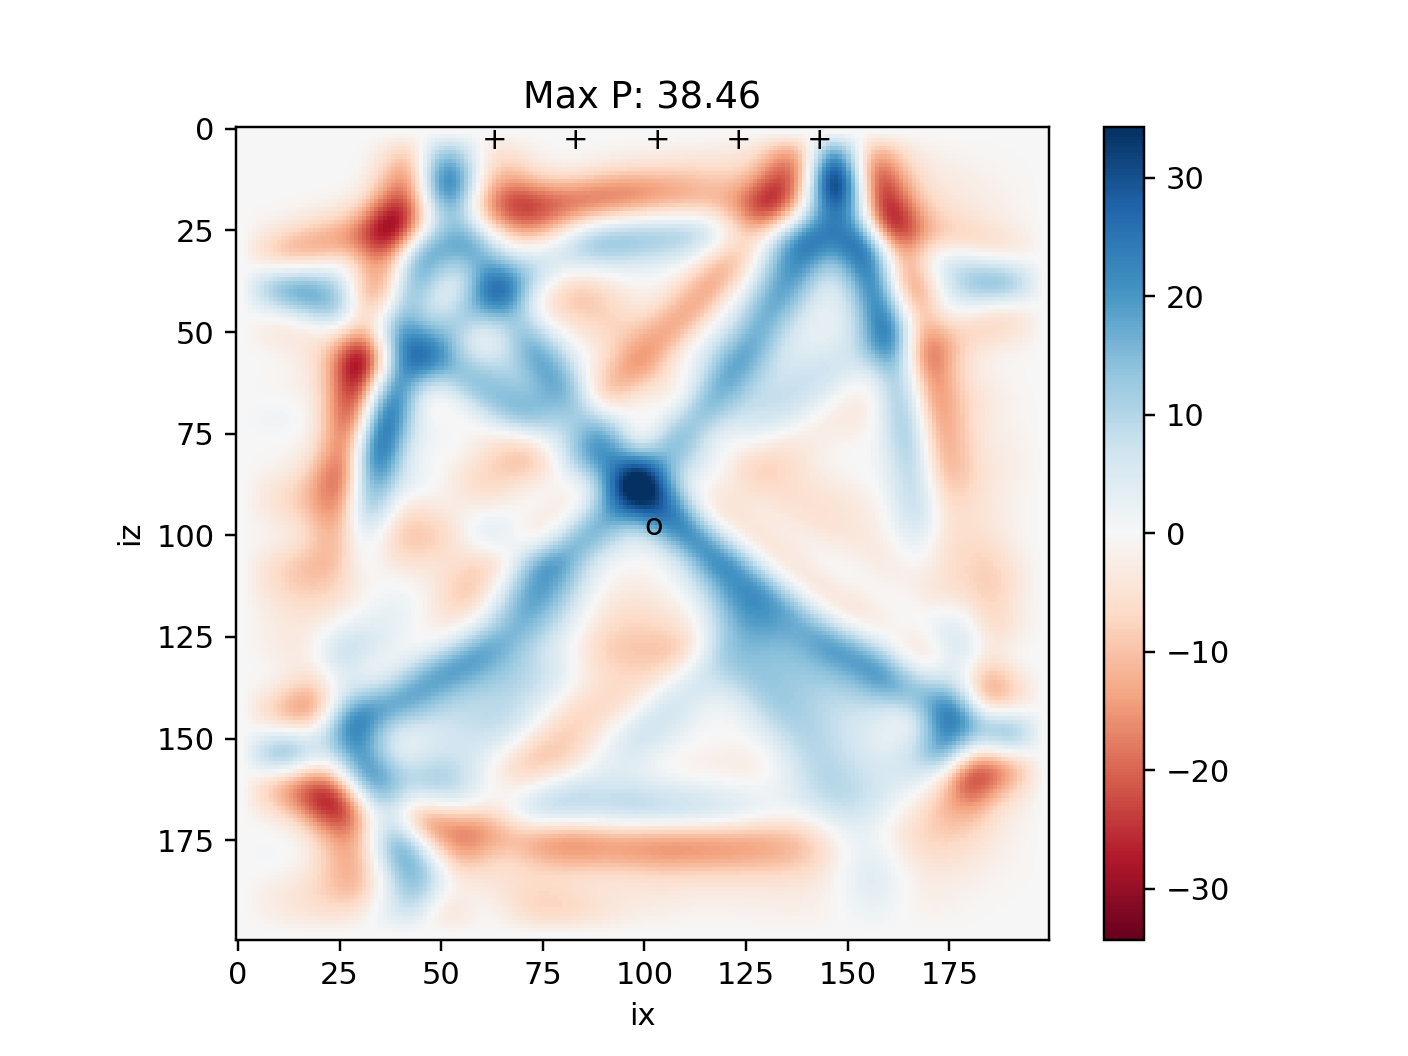

Courant Criterion eps :
0.42000000000000004


In [87]:
# Plot preparation

v = max([np.abs(src.min()), np.abs(src.max())])

# Initialize animated plot
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-v, vmax=+v, cmap=plt.cm.RdBu)


# Plot the receivers
for x, z in zip(irx, irz):
    plt.text(x, z, '+')

plt.text(isx, isz, 'o')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')


plt.ion()
#plt.show(block=False)

# required for seismograms
ir = np.arange(len(irx))

# Output Courant criterion
print("Courant Criterion eps :")
print(cmax*dt/dx)

In [88]:
# Time extrapolation
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(1, nx - 1):
            pzz[:, i] = p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]
        for j in range(1, nz - 1):
            pxx[j, :] = p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(2, nx - 2):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in range(2, nz - 2):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                    
            
    pxx /= dx ** 2
    pzz /= dx ** 2

    # Time extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.title("Max P: %.2f" % p.max())
        image.set_data(pnew)
        plt.gcf().canvas.draw()

    pold, p = p, pnew

    # Save seismograms - pressure is only recorded at the receiver locations
    seis[ir, it] = p[irz[ir], irx[ir]]

The cell below allows you to plot source time function, seismic velocites, and the resulting seismograms in windows inside the notebook. Remember to rerun after you simulated again!

<IPython.core.display.Javascript object>


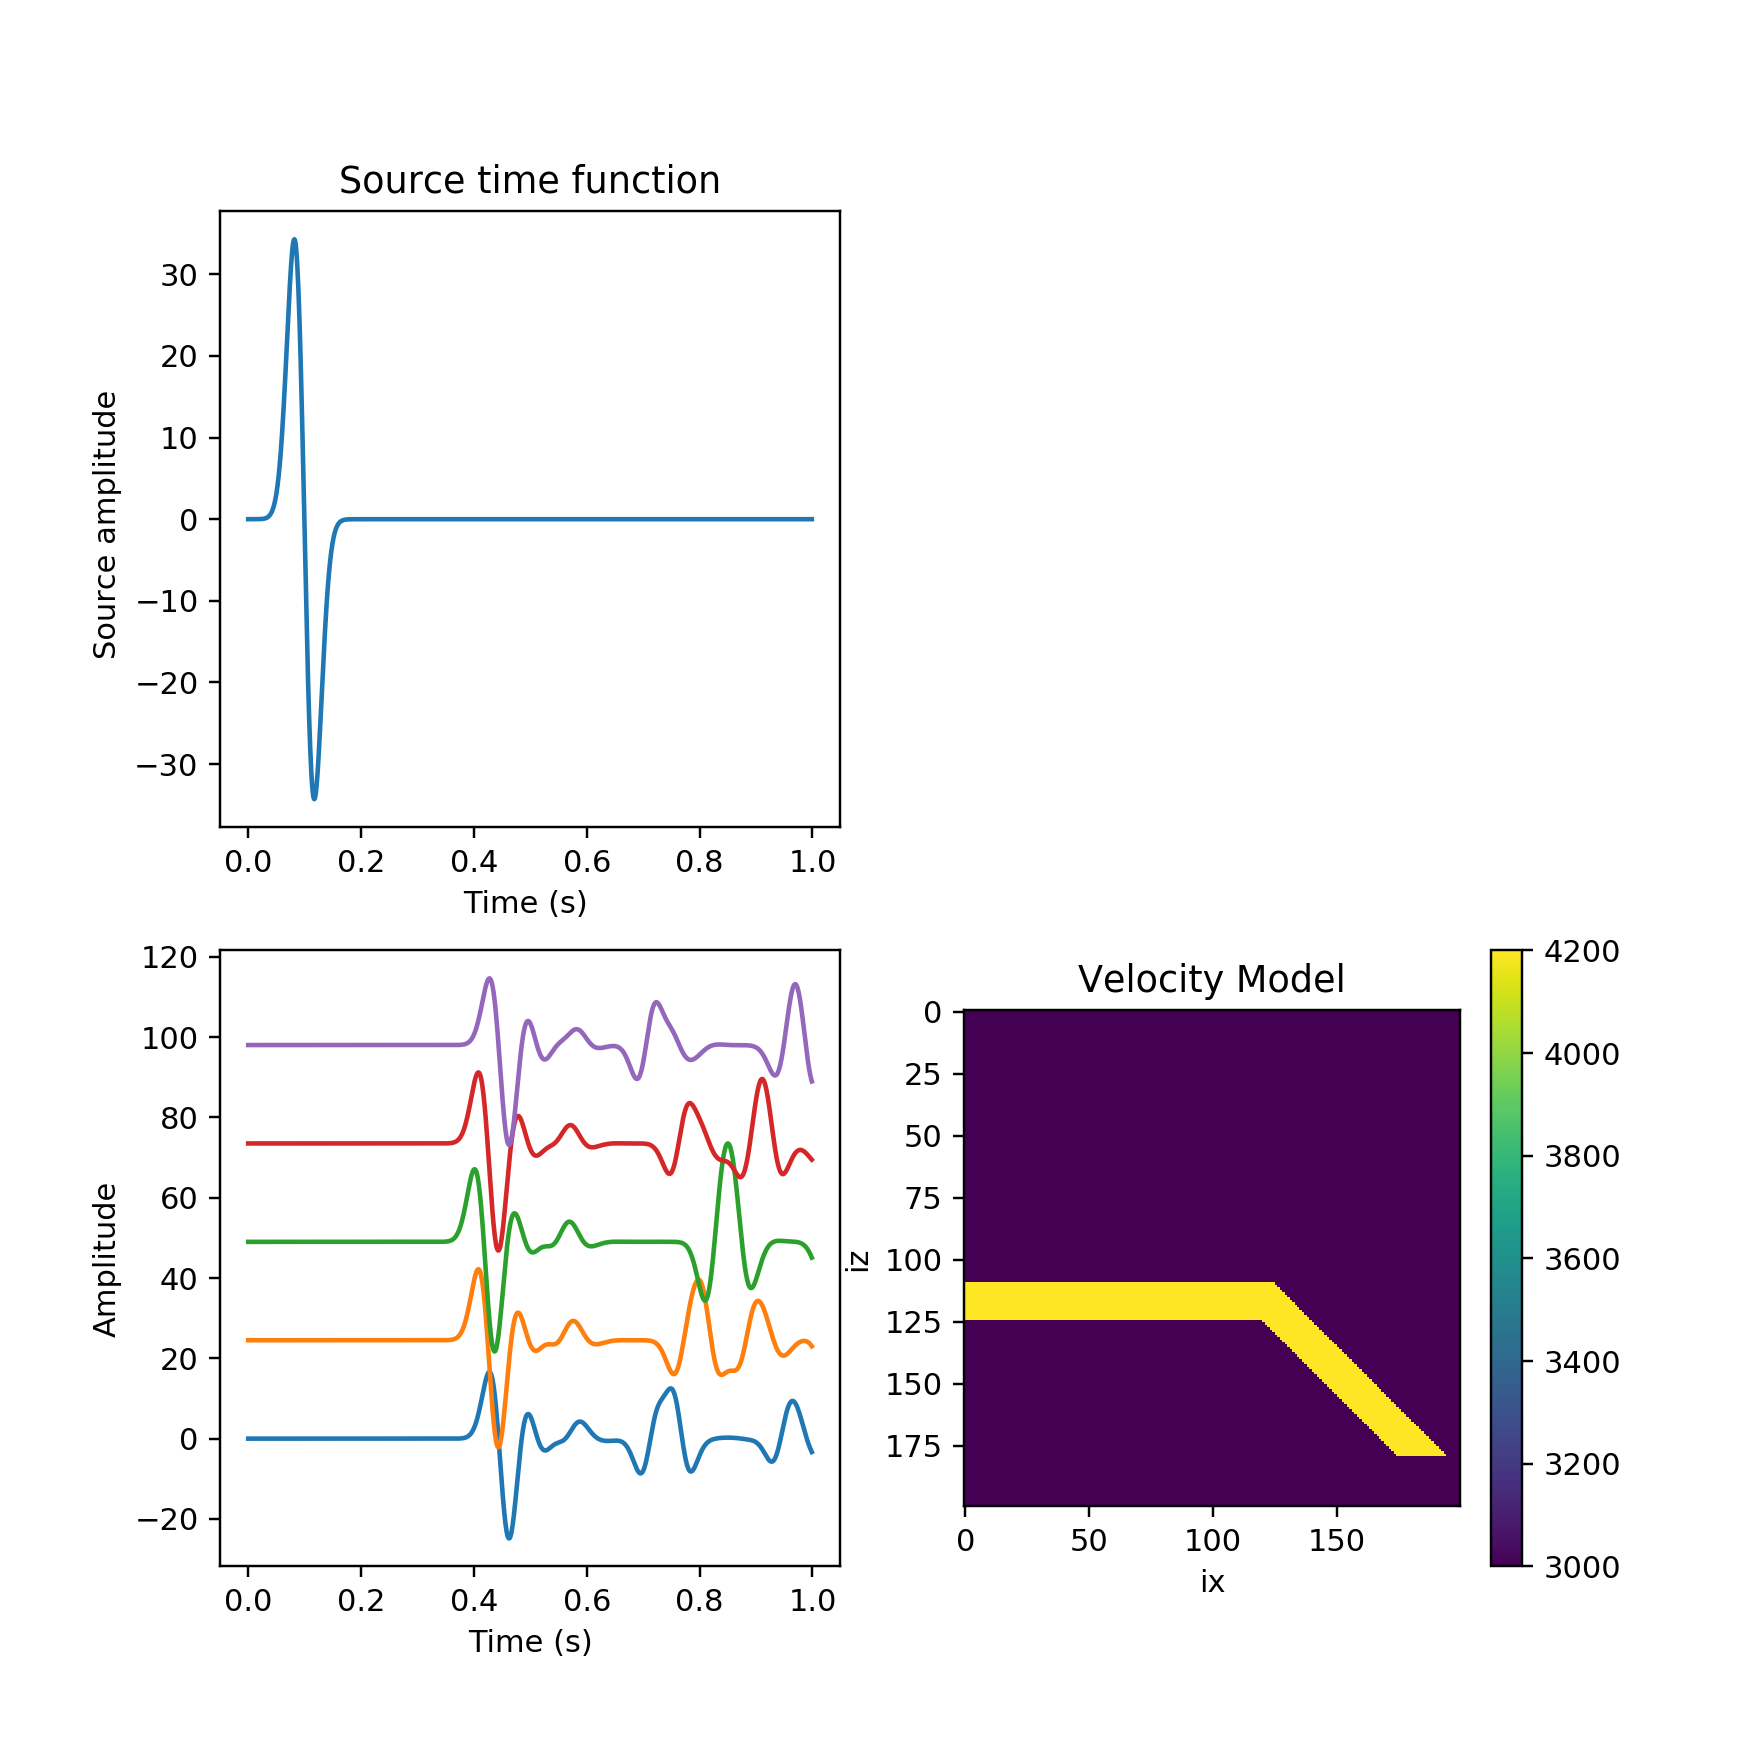

In [89]:
# Plot the source time function and the seismograms 

plt.ioff()
plt.figure(figsize=(8, 8))

plt.subplot(221)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

#plt.subplot(222)
#ymax = seis.ravel().max()  
#for ir in range(len(seis)):
#    plt.plot(time, seis[ir, :] + ymax * ir)
#    plt.xlabel('Time (s)')
#    plt.ylabel('Amplitude')

plt.subplot(223)
ymax = seis.ravel().max()
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(224)
# The velocity model is the Earth model above
plt.title('Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()